# 1. Introduction: Synthetic Sonic Curves Generation

## 1.1. Background

Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

## 1.2. Problem Statement

Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation.

## 1.3. Data Decription

- curve: DEPT, Units: M, Description: Measured Depth
- Curve: CALI, Units: in, Description: CALIPER
- Curve: DRHO, Units: g/cm3, Description: BULK DENSITIY CORRECTION
- Curve: EFAC, Units: Adim, Description: ELETROFACIES
- Curve: GR, Units: gAPI, Description: GAMMA RAY
- Curve: ILD, Units: ohm.m, Description: INDUCTION DEEP RESISTIVITY
- Curve: NPHI, Units: %, Description: THERMAL NEUTRON POROSITY (ORIGINAL RATIO METHOD) IN SELECTED LITHOLOGY
- Curve: RHOB, Units: g/cm3, Description: BULK DENSITY
- Curve: SN, Units: ohm.m, Description: SHORT NORMAL RESISTIVITY
- Curve: SP, Units: mV, Description: SPONTANEOUS POTENTIAL
- Curve: TENS, Units: lbf, Description: LINE TENSION
- Curve: VSH, Units: v/v, Description: VOLUME DE FOLHELHO

There are a total ofs: 12 curves present within this file

## 1.4. Evaluation Metric

We will be evaluated by the metirc Root Mean Squared Error.

The RMSE is calculated as:

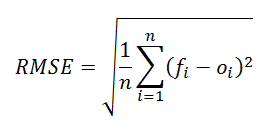

In [251]:
from IPython.display import Image
Image(filename='RMSE.png')

Where:

- "Fi" is the predicted curve for DTC and DTS
- "Oi" is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

In [252]:
# import libraries
import pandas as pd
import numpy as np
import lasio

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor

In [253]:
las = lasio.read("7-LP-80-ES.las")

# 1.3. Data Decription

In [278]:
well = (las.df()).reset_index()
well.tail()

,DEPT,CALI,DRHO,EFAC,GR,ILD,NPHI,RHOB,SN,SP,TENS,VSH
3606,1699.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3607,1699.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3608,1699.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3609,1699.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3610,1700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [259]:
well.describe()

,DEPT,CALI,DRHO,EFAC,GR,ILD,NPHI,RHOB,SN,SP,TENS,VSH
count,3611.000000,3121.000000,1421.000000,501.000000,3090.000000,3135.000000,1411.000000,1421.000000,3140.000000,3131.000000,3156.000000,1876.000000
mean,1339.000000,9.176998,0.080920,1.932136,103.148184,1.172191,34.724431,2.347699,1.740756,25.328189,1861.445423,0.790570
std,208.510048,0.833751,0.040063,1.335434,17.408095,1.478725,8.355232,0.056379,1.741338,21.527047,177.549196,0.364833
min,978.000000,7.751300,0.009400,1.000000,53.489700,0.380300,6.316400,2.151100,1.006800,-49.307100,1485.000000,0.000000
25%,1158.500000,8.726600,0.046400,1.000000,94.675800,0.867000,27.141500,2.315200,1.219000,10.121100,1707.734375,0.802725
50%,1339.000000,8.959200,0.079100,1.000000,106.767550,0.975000,37.121100,2.350100,1.327400,23.011500,1873.000000,1.000000
75%,1519.500000,9.388600,0.110700,4.000000,113.989725,1.082150,41.300800,2.379600,1.485575,44.238300,2025.000000,1.000000
max,1700.000000,14.597700,0.201900,4.000000,151.582000,22.707000,50.985600,2.610200,20.912800,68.691400,2207.437500,1.000000


In [183]:
well.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3611 entries, 0 to 3610
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPT    3611 non-null   float64
 1   CALI    3121 non-null   float64
 2   DRHO    1421 non-null   float64
 3   EFAC    501 non-null    float64
 4   GR      3090 non-null   float64
 5   ILD     3135 non-null   float64
 6   NPHI    1411 non-null   float64
 7   RHOB    1421 non-null   float64
 8   SN      3140 non-null   float64
 9   SP      3131 non-null   float64
 10  TENS    3156 non-null   float64
 11  VSH     1876 non-null   float64
dtypes: float64(12)
memory usage: 338.7 KB


## 5. Exploratory Data Analysis

In [281]:
well.dropna(axis=0, inplace=True)
well = well.reset_index(drop = True)
well.describe()

,DEPT,CALI,DRHO,EFAC,GR,ILD,NPHI,RHOB,SN,SP,TENS,VSH
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,1550.000000,8.464074,0.054963,1.932136,88.856698,2.158889,28.021996,2.324476,3.816959,29.060105,2088.202103,0.316620
std,28.954102,0.220287,0.030073,1.335434,27.477840,3.487063,7.417919,0.066697,3.559616,24.324899,26.718894,0.410241
min,1500.000000,8.170000,0.009400,1.000000,53.489700,0.465600,11.843800,2.209900,1.318300,-3.078100,2030.000000,0.000000
25%,1525.000000,8.306000,0.032300,1.000000,66.101600,0.771700,23.292700,2.270000,1.716900,8.441400,2067.375000,0.000000
50%,1550.000000,8.366000,0.046800,1.000000,73.886700,1.279500,25.808600,2.305800,2.651700,16.179700,2088.000000,0.000000
75%,1575.000000,8.638100,0.072500,4.000000,119.464800,1.661900,33.039100,2.384300,4.678000,59.656200,2103.562500,0.775100
max,1600.000000,8.948500,0.185400,4.000000,151.582000,22.707000,50.985600,2.550900,20.912800,68.691400,2196.250000,1.000000


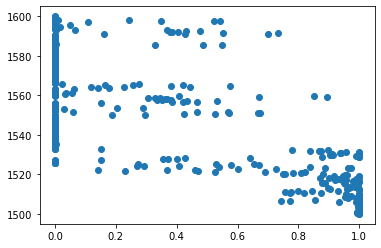

In [282]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
plt.scatter(well['VSH'], well['DEPT'])

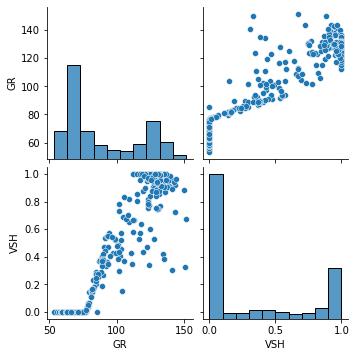

In [283]:
sb.pairplot(well[['GR', 'VSH']])

# 6. Build Machine Learning Models

In [222]:
# seperate the features and targets
well = np.array(well)
y_trainwell1 = well[:,-2:]
x_trainwell1 = well[:,:-2]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [223]:
well[:,-2:]

array([[2.0544375e+03, 1.0000000e+00],
       [2.0881250e+03, 1.0000000e+00],
       [2.0568750e+03, 1.0000000e+00],
       ...,
       [2.1030000e+03, 0.0000000e+00],
       [2.1030000e+03, 0.0000000e+00],
       [2.0926250e+03, 0.0000000e+00]])

In [224]:
np.shape(y_trainwell1)
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)

In [225]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [240]:
def result_plot(y_predict, y_real=y_trainwell1):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('TENS Predicted Value')
    plt.title('TENS')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('VSH')
    plt.title('VSH')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('TENS Predicted Value')
    plt.title('TENS')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('VSH Predicted Value')
    plt.title('VSH ')

    plt.show()

In [246]:
y_trainwell1

array([[2.0544375e+03, 1.0000000e+00],
       [2.0881250e+03, 1.0000000e+00],
       [2.0568750e+03, 1.0000000e+00],
       ...,
       [2.1030000e+03, 0.0000000e+00],
       [2.1030000e+03, 0.0000000e+00],
       [2.0926250e+03, 0.0000000e+00]])

0.5777447674771484
Root Mean Square Error is: 16.33106


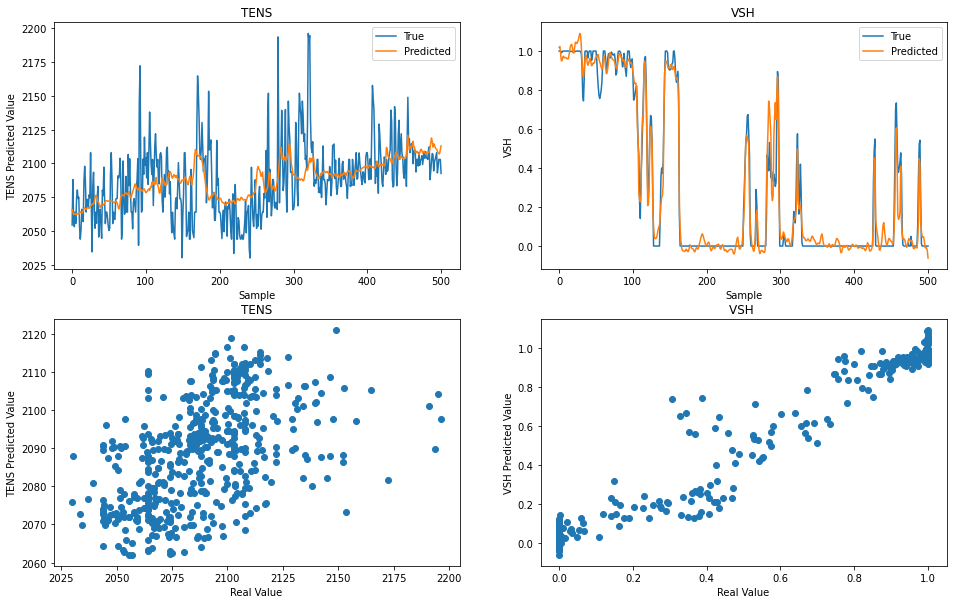

In [241]:
# Linear regression model as the baseline
LR = LinearRegression()
LR_best = grid_search(LR, {})
LR_predict = LR_best.predict(x_trainwell1)
result_plot(LR_predict, y_trainwell1)

0.7366756336546482
Root Mean Square Error is: 7.11398


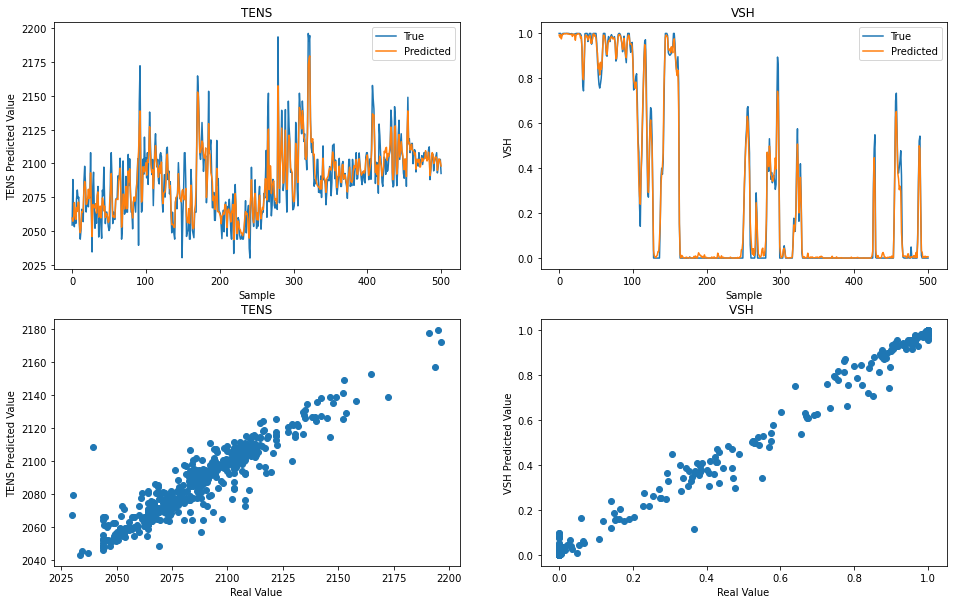

In [245]:
# Random forest model
RF = RandomForestRegressor(n_estimators=100, random_state=100)
RF_best = grid_search(RF, {})
result_plot(RF_best.predict(x_trainwell1), y_trainwell1)

Root Mean Square Error is: 12.35218


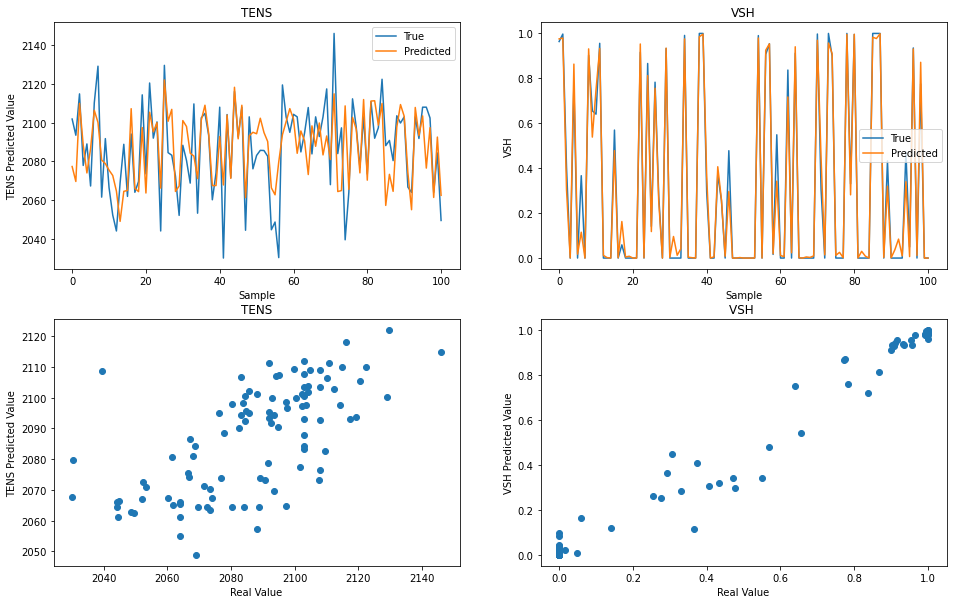

In [244]:
# check the result on test dataset only
result_plot(RF_best.predict(X_test), y_test)

In [231]:
# load test data from well 2
df2 = lasio.read("7-LP-81-ES.las")
df2 = (df2.df()).reset_index()

df2.dropna(axis=0, inplace=True)
df2 = df2.reset_index(drop = True)
df2 = df2.drop(['NPD', 'NPS', 'TENS','VSH'], axis=1)

df2_data = np.array(df2)
x_trainwell2 = df2_data
x_trainwell2 = scaler.transform(x_trainwell2)

In [232]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)
well2_predict[:5, :]

array([[2.08039449e+03, 9.41547000e-01],
       [2.08069886e+03, 9.40513000e-01],
       [2.07938168e+03, 9.34503000e-01],
       [2.07946511e+03, 9.38750000e-01],
       [2.07995105e+03, 9.39458000e-01]])

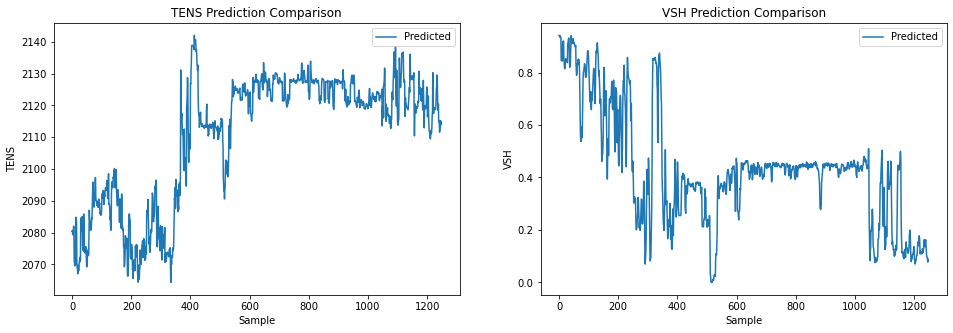

In [234]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('TENS')
plt.title('TENS Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('VSH')
plt.title('VSH Prediction Comparison')
plt.show()

In [285]:
well.columns

Index(['DEPT', 'CALI', 'DRHO', 'EFAC', 'GR', 'ILD', 'NPHI', 'RHOB', 'SN', 'SP',
       'TENS', 'VSH'],
      dtype='object')

KeyError: 'NEU'

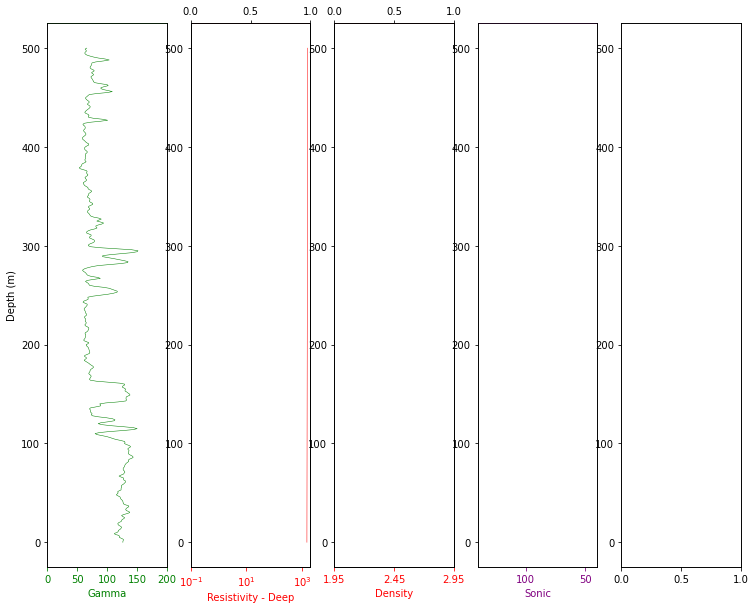

In [287]:
fig, ax = plt.subplots(figsize=(15,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1)
ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
ax5 = ax3.twiny() #Twins the y-axis for the density track with the neutron track
ax6 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)
ax7 = ax2.twiny()

# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax10 = ax1.twiny()
ax10.xaxis.set_visible(False)
ax11 = ax2.twiny()
ax11.xaxis.set_visible(False)
ax12 = ax3.twiny()
ax12.xaxis.set_visible(False)
ax13 = ax4.twiny()
ax13.xaxis.set_visible(False)
ax14 = ax6.twiny()
ax14.xaxis.set_visible(False)

# Gamma Ray track
ax1.plot(well["GR"], well.index, color = "green", linewidth = 0.5)
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")
ax1.set_xlim(0, 200)
ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150, 200])

# Resistivity track
ax2.plot(well["DEPT"], well.index, color = "red", linewidth = 0.5)
ax2.set_xlabel("Resistivity - Deep")
ax2.set_xlim(0.2, 2000)
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
ax2.set_xticks([0.1, 1, 10, 100, 1000])
ax2.semilogx()

# Density track
ax3.plot(well["VSH"], well.index, color = "red", linewidth = 0.5)
ax3.set_xlabel("Density")
ax3.set_xlim(1.95, 2.95)
ax3.xaxis.label.set_color("red")
ax3.tick_params(axis='x', colors="red")
ax3.spines["top"].set_edgecolor("red")
ax3.set_xticks([1.95, 2.45, 2.95])

# Sonic track
ax4.plot(well["ILD"], well.index, color = "purple", linewidth = 0.5)
ax4.set_xlabel("Sonic")
ax4.set_xlim(140, 40)
ax4.xaxis.label.set_color("purple")
ax4.tick_params(axis='x', colors="purple")
ax4.spines["top"].set_edgecolor("purple")

# Neutron track placed ontop of density track
ax5.plot(well["NEU"], well.index, color = "blue", linewidth = 0.5)
ax5.set_xlabel('Neutron')
ax5.xaxis.label.set_color("blue")
ax5.set_xlim(45, -15)
ax5.set_ylim(4150, 3500)
ax5.tick_params(axis='x', colors="blue")
ax5.spines["top"].set_position(("axes", 1.08))
ax5.spines["top"].set_visible(True)
ax5.spines["top"].set_edgecolor("blue")
ax5.set_xticks([45,  15, -15])

# Caliper track
ax6.plot(well["CALI"], well.index, color = "black", linewidth = 0.5)
ax6.set_xlabel("Caliper")
ax6.set_xlim(6, 16)
ax6.xaxis.label.set_color("black")
ax6.tick_params(axis='x', colors="black")
ax6.spines["top"].set_edgecolor("black")
ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
ax6.set_xticks([6,  11, 16])

# Resistivity track - Curve 2
ax7.plot(well["RMED"], well.index, color = "green", linewidth = 0.5)
ax7.set_xlabel("Resistivity - Med")
ax7.set_xlim(0.2, 2000)
ax7.xaxis.label.set_color("green")
ax7.spines["top"].set_position(("axes", 1.08))
ax7.spines["top"].set_visible(True)
ax7.tick_params(axis='x', colors="green")
ax7.spines["top"].set_edgecolor("green")
ax7.set_xticks([0.1, 1, 10, 100, 1000])
ax7.semilogx()


# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax3, ax4, ax6]:
    ax.set_ylim(4500, 3500)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
for ax in [ax2, ax3, ax4, ax6]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.15)